# Model for TT

So basically the plan is to use this notebook for my attempts to both clear up stuff on model creation as well as making the stuff work properly for our case 

## Basics

I will be using PyTorch as that is pretty much the industry standard for DL and for general stuff scikit-learn. But I will start with PyTorch as my aim is DNNs and not classical ML for this notebook

In [2]:
import torch
import torch.nn as nn  # tools for neural networks
import torch.optim as optim  # optimising stuff like SGD

In [3]:
# a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        # fc - fully connected (aka linear/dense layer)
        # means that is is like y = xW + b (y = output, x = input, W = weight, b = bias)
        self.fc1 = nn.Linear(2, 3)  # Layer with 2 inp and 3 output
        self.fc2 = nn.Linear(3, 1)  # Layer with 3 inp and 1 output
    def forward(self, x):  # how forward calc are done, i.e., forward pass def
        x = torch.relu(self.fc1(x))  # add relu activation function - normal stuff (to remove linearity)
        x = self.fc2(x)
        return x

model = SimpleNN()
criteria = nn.MSELoss()  # How loss is calculated
optimiser = optim.SGD(model.parameters(), lr=0.01)  # learning rate = 0.01 and .parameters - all the weights and bias in this case

In [4]:
input_data = torch.tensor([[1.0, 2.0]])  # create the input and output data examples
target = torch.tensor([[3.0]])

output = model(input_data)  # feed the data in
loss = criteria(output, target)

# only 1 pass for simplicity

# it can be useful not to use this - if you want gradient accumulation, so let the thing update for a bit then update it so as to work with stuff and simulate larger batch sizes
optimiser.zero_grad()  # Clear previous gradients as if you don't the newly updated gradient will add up
loss.backward()  # Back propagation to get gradients
optimiser.step()  # Update the weights and biases

print(f'Output: {output.item()}, Loss: {loss.item()}')

Output: -0.07392764091491699, Loss: 9.449030876159668


In [5]:
model = SimpleNN()
criteria = nn.MSELoss()  # How loss is calculated
optimiser = optim.SGD(model.parameters(), lr=0.01)  # learning rate = 0.01 and .parameters - all the weights and bias in this case

# Example dataset - By Deepseek
X = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0]])
y = torch.tensor([[3.0], [5.0], [7.0]])

# Training loop
for epoch in range(100):
    # Forward pass
    output = model(X)
    loss = criteria(output, y)

    # Backward pass
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 10, Loss: 23.272619247436523
Epoch 20, Loss: 16.423364639282227
Epoch 30, Loss: 11.850749969482422
Epoch 40, Loss: 8.798033714294434
Epoch 50, Loss: 6.760015964508057
Epoch 60, Loss: 5.39941930770874
Epoch 70, Loss: 4.491074085235596
Epoch 80, Loss: 3.8846566677093506
Epoch 90, Loss: 3.479806900024414
Epoch 100, Loss: 3.2095258235931396


In [6]:
# Save the model - the way to do so
# pth - pytorch file
# state_dict() - keys are names of layers and values are their weights and biases as tensors
torch.save(model.state_dict(), 'model.pth')

# Load the model
model = SimpleNN()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

## Actual Implementation

According to DeepSeek for tabular data SNN are a good starting point, so will start with it. Also note, I am classifying the dataset as tablular and not time series even though we have timestamps is simply because the past performance wouldn't not be considered for now. But ideally, it needs to be, say for example, if an aircraft is consistenly late it should effect the prediction - but for now - f it.

Also if we treat it as time series, we will need features for - events like landing, taxxing, refuling and boarding. Some of these can be figured out or similar can be, but for now as I stated - f it.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load datasets
train_df = pd.read_csv("train.csv")
testing_df = pd.read_csv("test.csv")

# Drop unnecessary columns
drop_cols = ["Unnamed: 0.1", "Unnamed: 0", "datetime", "start_time"]
train_df.drop(columns=drop_cols, inplace=True, errors="ignore")
testing_df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Convert datetime columns
for df in [train_df, testing_df]:
    df["start_datetime"] = pd.to_datetime(df["start_datetime"], errors="coerce")
    df["end_datetime"] = pd.to_datetime(df["end_datetime"], errors="coerce")

    # Extract date-time features
    for prefix in ["start", "end"]:
        df[f"{prefix} year"] = df[f"{prefix}_datetime"].dt.year
        df[f"{prefix} month"] = df[f"{prefix}_datetime"].dt.month
        df[f"{prefix} day"] = df[f"{prefix}_datetime"].dt.day
        df[f"{prefix} hour"] = df[f"{prefix}_datetime"].dt.hour
        df[f"{prefix} minute"] = df[f"{prefix}_datetime"].dt.minute
        df[f"{prefix} second"] = df[f"{prefix}_datetime"].dt.second

    df.drop(columns=["start_datetime", "end_datetime"], inplace=True, errors="ignore")

# Encode categorical features (binary conversion)
for df in [train_df, testing_df]:
    df.rename(columns={"flight_type": "international"}, inplace=True)
    df["international"] = (df["international"] == "international").astype(bool)

    df.rename(columns={"haul_type": "long_haul"}, inplace=True)
    df["long_haul"] = (df["long_haul"] == "Long Haul").astype(bool)

# Encode 'mode_s_hex' and 'callsign' with Label Encoding, ensuring unseen labels in test are handled
label_encoders = {}
for col in ["mode_s_hex", "callsign"]:
    le = LabelEncoder()
    train_df[col + "_encoded"] = le.fit_transform(train_df[col].fillna("Unknown"))
    
    # Create a mapping dictionary
    label_map = {label: idx for idx, label in enumerate(le.classes_)}
    
    # Apply the mapping to test data, assigning -1 to unseen labels
    testing_df[col + "_encoded"] = testing_df[col].fillna("Unknown").map(label_map).fillna(-1).astype(int)
    
    label_encoders[col] = le  # Store the encoder for optional decoding

# Drop original categorical ID columns
train_df.drop(columns=["mode_s_hex", "callsign"], inplace=True, errors="ignore")
testing_df.drop(columns=["mode_s_hex", "callsign"], inplace=True, errors="ignore")

# Drop columns with all NaN values
train_df.dropna(axis=1, how="all", inplace=True)
testing_df.dropna(axis=1, how="all", inplace=True)

# Print dataset info
print(train_df.columns, "\nCount:", len(train_df.columns))
print(train_df)


Index(['turnaroundtime_s', 'international', 'long_haul', 'cavok', 'temp_C',
       'dew_point_C', 'QNH_hPa', 'windspeed_kts', 'wind_dir_deg',
       'wind_minvar_deg', 'wind_maxvar_deg', 'base_viz_m', 'viz_dist_min_m',
       'viz_dir_min_m', 'cloud_height_layer_0', 'cloud_quant_layer_0',
       'cloud_type_layer_0', 'cloud_height_layer_1', 'cloud_quant_layer_1',
       'cloud_type_layer_1', 'met_type_0', 'met_intensity_0', 'start year',
       'start month', 'start day', 'start hour', 'start minute',
       'start second', 'end year', 'end month', 'end day', 'end hour',
       'end minute', 'end second', 'mode_s_hex_encoded', 'callsign_encoded'],
      dtype='object') 
Count: 36
       turnaroundtime_s  international  long_haul cavok  temp_C  dew_point_C  \
0                  3360          False      False   NaN     0.0          0.0   
1                  4380          False      False   NaN     1.0          1.0   
2                  7200          False       True   NaN     1.0        

Epoch 1/100, Loss: 0.3586, Val Loss: 0.2963, MAE: 1054.92, R²: 0.23
Epoch 2/100, Loss: 0.3175, Val Loss: 0.2839, MAE: 1020.41, R²: 0.26
Epoch 3/100, Loss: 0.3036, Val Loss: 0.2820, MAE: 1026.79, R²: 0.26
Epoch 4/100, Loss: 0.2972, Val Loss: 0.2786, MAE: 994.56, R²: 0.19
Epoch 5/100, Loss: 0.2860, Val Loss: 0.2739, MAE: 984.07, R²: 0.20
Epoch 6/100, Loss: 0.2808, Val Loss: 0.2816, MAE: 999.91, R²: 0.08
Epoch 7/100, Loss: 0.2761, Val Loss: 0.2663, MAE: 978.54, R²: 0.17
Epoch 8/100, Loss: 0.2688, Val Loss: 0.2602, MAE: 952.88, R²: 0.19
Epoch 9/100, Loss: 0.2698, Val Loss: 0.2587, MAE: 957.53, R²: 0.10
Epoch 10/100, Loss: 0.2598, Val Loss: 0.2551, MAE: 941.96, R²: 0.05
Epoch 11/100, Loss: 0.2598, Val Loss: 0.2566, MAE: 945.94, R²: 0.20
Epoch 12/100, Loss: 0.2562, Val Loss: 0.2509, MAE: 934.08, R²: 0.21
Epoch 13/100, Loss: 0.2534, Val Loss: 0.2469, MAE: 922.10, R²: 0.22
Epoch 14/100, Loss: 0.2513, Val Loss: 0.2491, MAE: 927.59, R²: 0.20
Epoch 15/100, Loss: 0.2551, Val Loss: 0.2439, MAE: 914

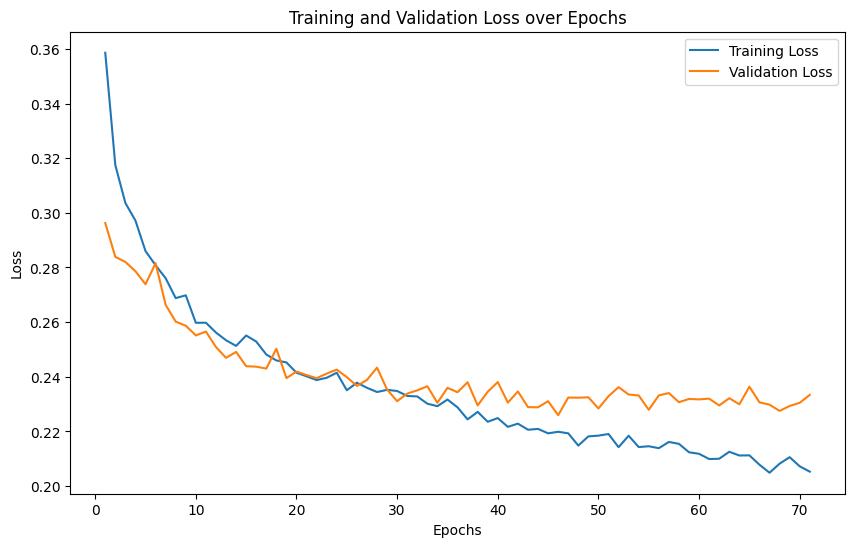

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load & Preprocess Data
df = train_df.copy()

# Drop columns with too many missing values
df = df.dropna(axis=1, thresh=int(0.8 * len(df)))

# Fill missing values
df.fillna(0, inplace=True)

# Separate features and target
X = df.drop(columns=['turnaroundtime_s']).values
y = df['turnaroundtime_s'].values.reshape(-1, 1)

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Scale output (turnaround time)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into training & validation sets
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define Improved Neural Network

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )

        self.regressor = nn.Linear(128, 1)

        for layer in self.feature_extractor:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.feature_extractor(x)
        return self.regressor(x)

# Initialize model
input_dim = X_tensor.shape[1]
model = RegressionNN(input_dim)

# Define loss function and optimizer
criterion = nn.HuberLoss(delta=1.0)  # More robust than MSE
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Initialize lists to track loss
train_losses = []
val_losses = []

# Training Loop with Validation
epochs = 100
best_val_loss = float("inf")
patience, patience_counter = epochs / 4, 0  # Early stopping criteria

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            val_loss += criterion(predictions, batch_y).item()
            
            # Collect actual & predicted values for performance metrics
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Compute MAE and R² Score
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Track losses for graph
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Error Absolute Value Table ---
error_abs = np.abs(y_true - y_pred)
error_df = pd.DataFrame({
    'True Value': y_true,
    'Predicted Value': y_pred,
    'Absolute Error': error_abs
})

print("\nError Absolute Value Table (for the final epoch):")
print(error_df.head())

# --- Final R² ---
final_r2 = r2_score(y_true, y_pred)
print(f"Final R² Score: {final_r2:.2f}")

# --- Error Graph ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


Error Absolute Value Table (for the final epoch):


,True Value,Predicted Value,Absolute Error
0,5880.0,4038.576172,1841.423828
1,3540.0,3481.204346,58.795654
2,3120.0,3195.396973,75.396973
3,3600.0,4145.637695,545.637695
4,6780.0,8430.837891,1650.837891
...,...,...,...
2175,4140.0,4108.556152,31.443848
2176,4200.0,4627.445801,427.445801
2177,3540.0,4914.930664,1374.930664
2178,3180.0,2435.654541,744.345459


Final R² Score: 0.35


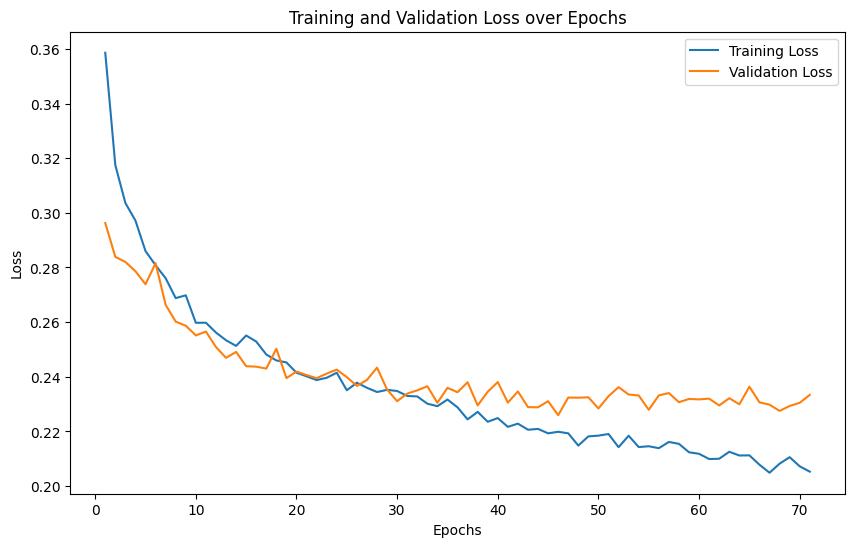

In [10]:
# --- Error Absolute Value Table ---
error_abs = np.abs(y_true - y_pred)
error_df = pd.DataFrame({
    'True Value': y_true,
    'Predicted Value': y_pred,
    'Absolute Error': error_abs
})

print("\nError Absolute Value Table (for the final epoch):")
display(error_df)

# --- Final R² ---
final_r2 = r2_score(y_true, y_pred)
print(f"Final R² Score: {final_r2:.2f}")

# --- Error Graph ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

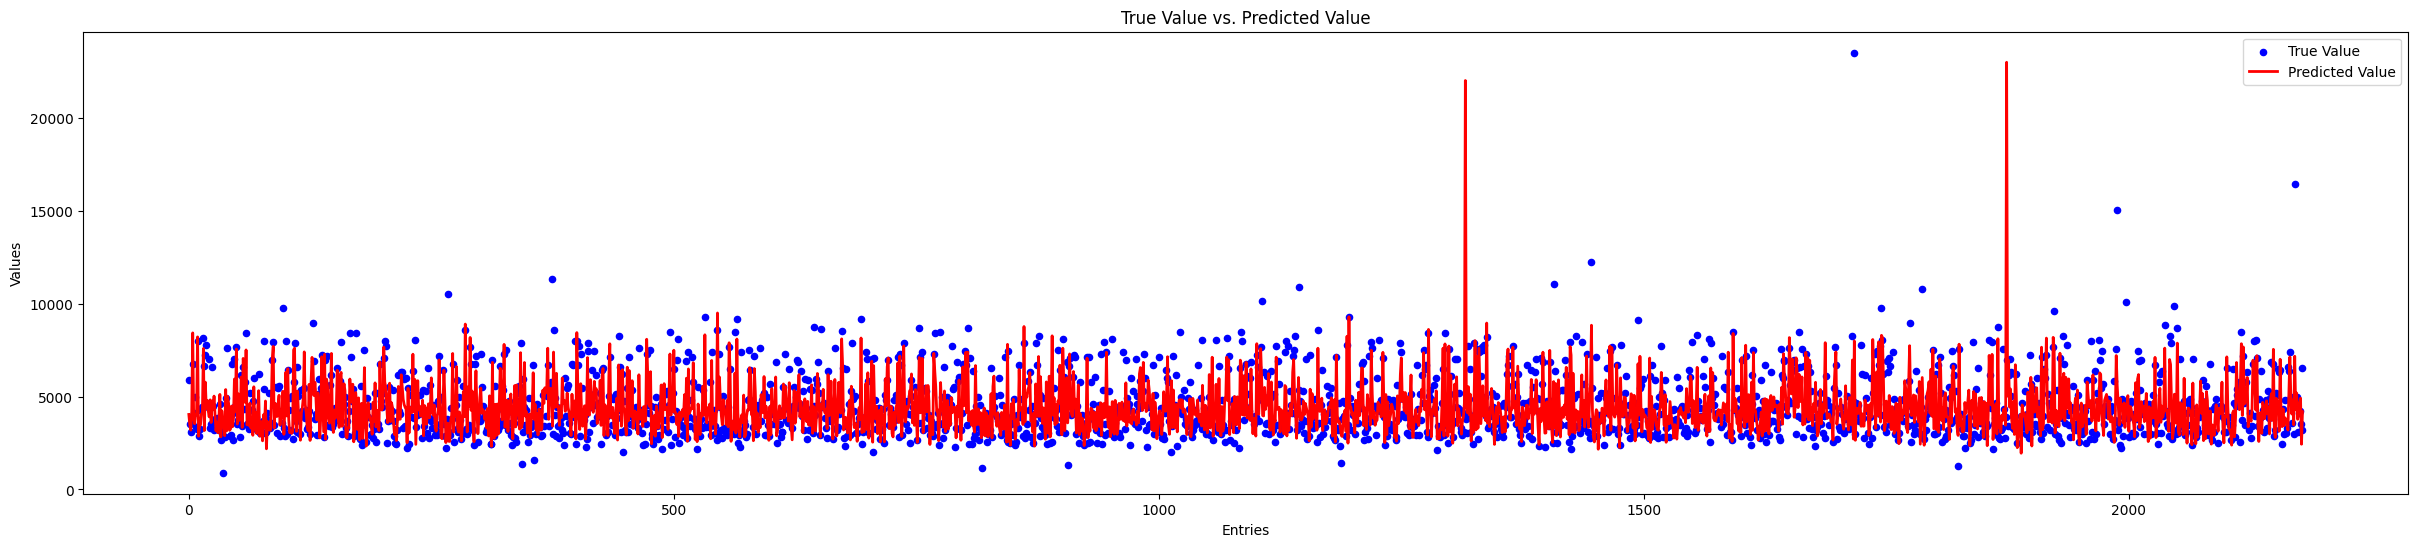

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the True Value as points and Predicted Value as a curve
plt.figure(figsize=(30, 6))

# Plot the 'True Value' as scatter points
plt.scatter(error_df.index, error_df['True Value'], label='True Value', color='blue', s=20)

# Plot the 'Predicted Value' as a smooth curve
plt.plot(error_df.index, error_df['Predicted Value'], label='Predicted Value', color='red', linewidth=2)

# Adding labels and title
plt.xlabel('Entries')
plt.ylabel('Values')
plt.title('True Value vs. Predicted Value')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()


In [12]:
from sklearn.metrics import r2_score

# Assuming y_true and y_pred are the true and predicted values
# Filter data points where true values are less than the maximum predicted value
mask = y_true < np.max(y_pred)

# Apply the mask to filter both true and predicted values
filtered_y_true = y_true[mask]
filtered_y_pred = y_pred[mask]

# Compute R² score for the filtered data
r2_filtered = r2_score(filtered_y_true, filtered_y_pred)

print(f"R² score for data points with true values less than the maximum predicted value: {r2_filtered:.2f}")


R² score for data points with true values less than the maximum predicted value: 0.35


In [13]:
# Save the model as v3.13.pth
torch.save(model.state_dict(), "v3.13.pth")


In [14]:
# Filter data points where true values (y) are less than 8000
mask = y_tensor.numpy().flatten() < 8000  # Create a mask based on the condition tt < 8000
filtered_X_tensor = X_tensor[mask]  # Apply mask to filter X
filtered_y_tensor = y_tensor[mask]  # Apply mask to filter y

# Split the filtered data into training and validation sets
train_size = int(0.8 * len(filtered_X_tensor))
val_size = len(filtered_X_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(filtered_X_tensor, filtered_y_tensor), [train_size, val_size])

# Create DataLoader for filtered data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [15]:
# Retrain the model on the filtered data
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            val_loss += criterion(predictions, batch_y).item()
            
            # Collect actual & predicted values for performance metrics
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Compute MAE and R² Score
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/100, Loss: 0.2156, Val Loss: 0.1851, MAE: 752.90, R²: 0.52
Epoch 2/100, Loss: 0.2111, Val Loss: 0.1884, MAE: 764.80, R²: 0.51
Epoch 3/100, Loss: 0.2105, Val Loss: 0.1921, MAE: 773.55, R²: 0.51
Epoch 4/100, Loss: 0.2115, Val Loss: 0.1901, MAE: 772.13, R²: 0.50
Epoch 5/100, Loss: 0.2108, Val Loss: 0.1962, MAE: 798.90, R²: 0.49
Epoch 6/100, Loss: 0.2088, Val Loss: 0.1976, MAE: 798.90, R²: 0.50
Epoch 7/100, Loss: 0.2091, Val Loss: 0.1929, MAE: 790.52, R²: 0.49
Epoch 8/100, Loss: 0.2046, Val Loss: 0.2033, MAE: 811.64, R²: 0.47
Epoch 9/100, Loss: 0.2089, Val Loss: 0.1970, MAE: 790.07, R²: 0.49
Epoch 10/100, Loss: 0.2061, Val Loss: 0.2035, MAE: 812.49, R²: 0.48
Epoch 11/100, Loss: 0.2058, Val Loss: 0.1982, MAE: 788.09, R²: 0.50
Epoch 12/100, Loss: 0.2062, Val Loss: 0.1989, MAE: 795.31, R²: 0.48
Epoch 13/100, Loss: 0.2054, Val Loss: 0.1981, MAE: 786.45, R²: 0.47
Epoch 14/100, Loss: 0.2011, Val Loss: 0.2002, MAE: 799.17, R²: 0.48
Epoch 15/100, Loss: 0.2057, Val Loss: 0.1991, MAE: 790.02

Epoch 1/50, Loss: 0.3912, Val Loss: 0.3336
Epoch 2/50, Loss: 0.3393, Val Loss: 0.3023
Epoch 3/50, Loss: 0.3206, Val Loss: 0.2953
Epoch 4/50, Loss: 0.3146, Val Loss: 0.2905
Epoch 5/50, Loss: 0.3043, Val Loss: 0.2854
Epoch 6/50, Loss: 0.2969, Val Loss: 0.2834
Epoch 7/50, Loss: 0.2956, Val Loss: 0.2813
Epoch 8/50, Loss: 0.2920, Val Loss: 0.2824
Epoch 9/50, Loss: 0.2858, Val Loss: 0.2865
Epoch 10/50, Loss: 0.2857, Val Loss: 0.2719
Epoch 11/50, Loss: 0.2810, Val Loss: 0.2728
Epoch 12/50, Loss: 0.2798, Val Loss: 0.2653
Epoch 13/50, Loss: 0.2753, Val Loss: 0.2679
Epoch 14/50, Loss: 0.2759, Val Loss: 0.2654
Epoch 15/50, Loss: 0.2728, Val Loss: 0.2661
Epoch 16/50, Loss: 0.2716, Val Loss: 0.2663
Epoch 17/50, Loss: 0.2710, Val Loss: 0.2595
Epoch 18/50, Loss: 0.2662, Val Loss: 0.2586
Epoch 19/50, Loss: 0.2648, Val Loss: 0.2572
Epoch 20/50, Loss: 0.2646, Val Loss: 0.2534
Epoch 21/50, Loss: 0.2624, Val Loss: 0.2540
Epoch 22/50, Loss: 0.2623, Val Loss: 0.2556
Epoch 23/50, Loss: 0.2637, Val Loss: 0.25

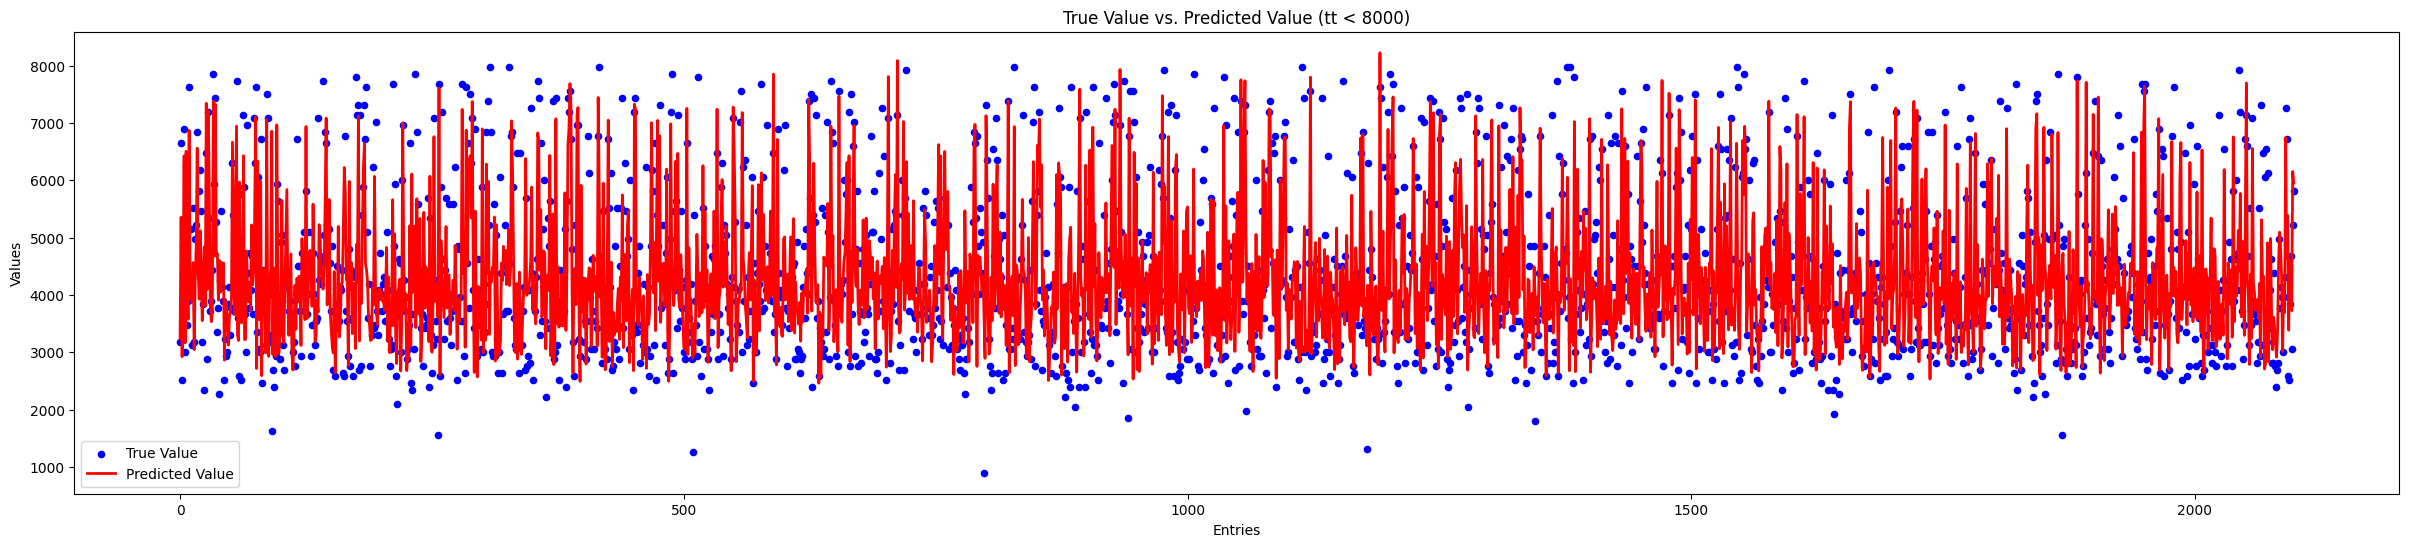

R² Score: 0.4350


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Filter the data for tt < 8000
filtered_df = df[df['turnaroundtime_s'] < 8000]

# Separate features and target again for the filtered data
X_filtered = filtered_df.drop(columns=['turnaroundtime_s']).values
y_filtered = filtered_df['turnaroundtime_s'].values.reshape(-1, 1)

# Scale the numerical features
X_filtered = scaler.fit_transform(X_filtered)
y_filtered = y_scaler.fit_transform(y_filtered)

# Convert to PyTorch tensors
X_tensor_filtered = torch.tensor(X_filtered, dtype=torch.float32)
y_tensor_filtered = torch.tensor(y_filtered, dtype=torch.float32)

# Split into training and validation sets
train_size_filtered = int(0.8 * len(X_tensor_filtered))
val_size_filtered = len(X_tensor_filtered) - train_size_filtered
train_dataset_filtered, val_dataset_filtered = random_split(TensorDataset(X_tensor_filtered, y_tensor_filtered), [train_size_filtered, val_size_filtered])

# Create DataLoader for training and validation
train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=32, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=32, shuffle=False)

# Initialize and train the model
model = RegressionNN(input_dim=X_tensor_filtered.shape[1])

# Define loss function and optimizer
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop for the filtered data
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader_filtered:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch_X, batch_y in val_loader_filtered:
            predictions = model(batch_X)
            val_loss += criterion(predictions, batch_y).item()
            
            # Collect actual & predicted values for performance metrics
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Convert to numpy arrays and inverse scale
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader_filtered):.4f}, Val Loss: {val_loss/len(val_loader_filtered):.4f}")

# After training, make predictions and plot
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader_filtered:
        predictions = model(batch_X)
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert to numpy arrays and inverse scale
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plotting the True Value as points and Predicted Value as a line graph
plt.figure(figsize=(30, 6))

# Plot the 'True Value' as scatter points
plt.scatter(np.arange(len(y_true)), y_true, label='True Value', color='blue', s=20)

# Plot the 'Predicted Value' as a line graph
plt.plot(np.arange(len(y_true)), y_pred, label='Predicted Value', color='red', linewidth=2)

# Adding labels and title
plt.xlabel('Entries')
plt.ylabel('Values')
plt.title('True Value vs. Predicted Value (tt < 8000)')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()

# Calculate and print R² score
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")


In [34]:
temp = pd.DataFrame([np.transpose(y_true), np.transpose(y_pred), (np.transpose(y_true) - np.transpose(y_pred))**2])
temp.iloc[2].mean()



np.float32(1185390.4)